In [36]:

import os, glob
import json
import numpy 
import tifffile

from matplotlib import pyplot
from skimage.filters import threshold_otsu
from tqdm.auto import tqdm

metadata = json.load(open(os.path.join(".", "datasets", "scraping", "metadata.json"), "r"))


In [45]:
snrs = []
for i, (key, value) in enumerate(tqdm(metadata.items())):

    image = tifffile.imread(value["path"])

    # Normalize image 
    m, M = numpy.quantile(image, [0.001, 0.999])
    if m == M: 
        continue    
    image = numpy.clip((image - m) / (M - m), 0, 1)
    
    threshold = threshold_otsu(image)
    foreground = image > threshold

    std = numpy.std(image[numpy.invert(foreground)])
    if std == 0:
        continue
    snr = numpy.mean(image[foreground]) / std

    snrs.append({
        "key" : key,
        "snr" : snr
    })


  0%|          | 0/46671 [00:00<?, ?it/s]

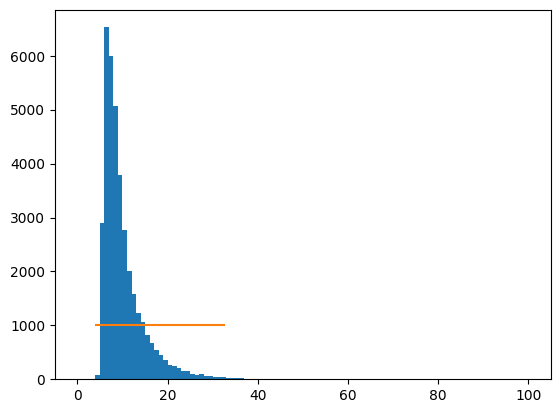

In [72]:
values = numpy.array([s["snr"] for s in snrs])
fig, ax = pyplot.subplots()
ax.hist(values, range=(0, 100), bins=100)
mean, std = numpy.mean(values), numpy.std(values)

median = numpy.median(values)
iqr = numpy.quantile(values, 0.75) - numpy.quantile(values, 0.25)

ax.plot([median - iqr, numpy.quantile(values, 0.99)], [1000, 1000])
pyplot.show()


In [76]:
argwhere = numpy.argwhere(values > numpy.quantile(values, 0.99))

# numpy.random.shuffle(argwhere)
# for i in argwhere[:10]:
#     i = i.item()
#     image = tifffile.imread(metadata[snrs[i]["key"]]["path"])
#     print(image.min(), image.max())

#     fig, ax = pyplot.subplots()
#     ax.imshow(image, cmap="gray", vmin=numpy.quantile(image, 0.01), vmax=numpy.quantile(image, 0.999))
#     ax.set_title(f"SNR: {values[i]}")
#     ax.axis("off")
#     pyplot.show()

# argwhere = numpy.argsort(values)
# for i in argwhere[:10]:
#     i = i.item()
#     image = tifffile.imread(metadata[snrs[i]["key"]]["path"])
#     print(image.min(), image.max())

#     fig, ax = pyplot.subplots()
#     ax.imshow(image, cmap="gray", vmin=numpy.quantile(image, 0.01), vmax=numpy.quantile(image, 0.999))
#     ax.set_title(f"SNR: {values[i]}")
#     ax.axis("off")
#     pyplot.show()    

In [81]:
argwhere = numpy.argwhere(values < numpy.quantile(values, 0.99))
updated_metadata = {}
for i in argwhere:
    i = i.item()
    key = snrs[i]["key"]
    updated_metadata[key] = metadata[key]
print(len(metadata), len(updated_metadata))

metadata = json.dump(updated_metadata, open(os.path.join(".", "datasets", "scraping", "metadata-updated.json"), "w"))

46671 37387
